# Bitcoin price prediction using XGBoost

## PartI. Preparation

### PartI-A Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
import csv

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [4]:
# library of XGboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

### PartI-B Self-defined functions

In [5]:
def add_days(start_date, window_size):
    # Convert the string to a datetime object
    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
    
    # Add the specified number of days
    end_date_obj = start_date_obj + timedelta(days=window_size)
    
    # Convert the datetime object back to a string
    end_date_str = end_date_obj.strftime("%Y-%m-%d")
    
    return end_date_str
    
def days_between_dates(start_date, end_date):
    # Convert the date strings to datetime objects
    start_date_obj = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Calculate the difference in days
    delta = end_date_obj - start_date_obj
    
    return delta.days

def mean_absolute_percentage_error(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def plot_predictions(data, y_pred, test_size):

    
    test_split_idx = int(data.shape[0] * (1 - test_size))
    predicted_prices = data.iloc[test_split_idx+1:].copy()
    predicted_prices['Close'] = y_pred

    y = data['Next_Day_BTC_Return']

    y_test = y.iloc[test_split_idx+1:].copy()
    
    # Create subplots
    fig = make_subplots(rows=2, cols=1)

    # Add traces for the first subplot
    fig.add_trace(go.Scatter(x=data.index, y=y,
                             name='Truth',
                             marker_color='lightgray'), row=1, col=1)
    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices["Close"],
                             name='Prediction',
                             marker_color='navy'), row=1, col=1)

    # Add traces for the second subplot
    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=y_test,
                             name='Truth',
                             marker_color='lightgray',
                             showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=predicted_prices.index,
                             y=predicted_prices['Close'],
                             name='Prediction',
                             marker_color='navy',
                             showlegend=False), row=2, col=1)

    # Show the plot
    fig.show()


### PartI-C Data preprocessing

In [42]:
data = pd.read_csv("data.csv")

data["Date"] =pd.to_datetime(data["Date"], format = '%d/%m/%y')
data.set_index("Date", inplace = True)

start_date = '2018-02-01'
end_date = '2024-08-31'

data = data.loc[start_date:end_date]
print(f'The day range is {days_between_dates(start_date, end_date)}')
print("data shape is: ", data.shape)

data.head()


The day range is 2403
data shape is:  (2404, 42)


,Volume,Number of Unique Addresses,Total Transactions,Miner Revenue,Hash Rate,Difficulty,Manpool Count,Average Block Size,Google Trends,positive_news_count,...,SGD/USD_return,RUB/USD_return,JPY/USD_return,GBP/USD_return,EUR/USD_return,CNY/USD_return,CAD/USD_return,AUD/USD_return,is_difficulty_updated,Next_Day_BTC_Return
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,9.959400e+09,531441,296046100,24473743.42,20216478.37,2.603080e+12,18227.989580,0.987509,28,537,...,0.000206,0.002478,-0.004349,0.003153,0.000732,0.005234,0.002772,-0.004917,0,-0.037052
2018-02-02,1.272690e+10,531441,296975108,24473743.42,20216478.37,2.603080e+12,18227.989580,0.987509,38,710,...,0.002332,0.004213,-0.001857,0.004665,0.007356,-0.001622,0.003377,-0.002574,0,0.038973
2018-02-03,7.263790e+09,436197,296975108,19143008.70,20216478.37,2.603080e+12,17048.213540,0.996567,25,429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.097865
2018-02-04,7.073550e+09,436197,296975108,19143008.70,19890578.53,2.603080e+12,17048.213540,0.996567,20,291,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,-0.159688
2018-02-05,9.285290e+09,436197,296975108,19143008.70,19890578.53,2.603080e+12,7665.494792,0.996567,36,878,...,-0.009435,-0.008336,-0.005689,-0.010894,-0.005042,-0.001455,-0.013787,-0.016682,0,0.114838


In [19]:
data.columns

Index(['Volume', 'Number of Unique Addresses', 'Total Transactions',
       'Miner Revenue', 'Hash Rate', 'Difficulty', 'Manpool Count',
       'Average Block Size', 'Google Trends', 'positive_news_count',
       'neutral_news_count', 'negative_news_count', 'avg_news_sentiment_score',
       'avg_stackex_sentiment_score', 'Fear & Greed Index', 'BTC_return',
       'DASH_return', 'DOGE_return', 'ETH_return', 'LTC_return', 'XRP_return',
       'Gold_return', 'Silver_return', 'Copper_return', 'Oil_return',
       'DXY_return', '10Y_Treasury_return', 'DJIA_return', 'SP500_return',
       'NASDAQ_return', 'JP225_return', 'CSI300_return', 'SGD/USD_return',
       'RUB/USD_return', 'JPY/USD_return', 'GBP/USD_return', 'EUR/USD_return',
       'CNY/USD_return', 'CAD/USD_return', 'AUD/USD_return',
       'is_difficulty_updated', 'Next_Day_BTC_Return'],
      dtype='object')

## PartII-Machine Learnings

### PartII-A Split data

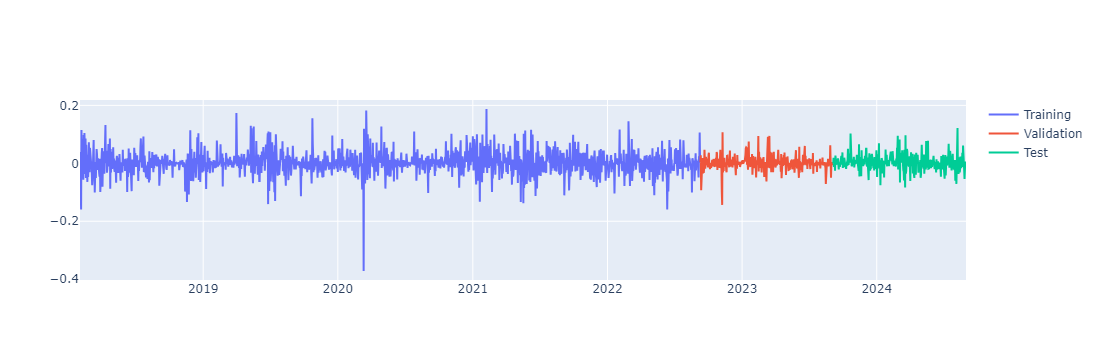

Date
2023-09-05   -0.001037
2023-09-06    0.018909
2023-09-07   -0.012749
2023-09-08   -0.000385
2023-09-09   -0.002450
                ...   
2024-08-26   -0.053697
2024-08-27   -0.008008
2024-08-28    0.006108
2024-08-29   -0.004525
2024-08-30   -0.002530
Name: Next_Day_BTC_Return, Length: 361, dtype: float64

In [33]:
X = data.drop(columns = ['Next_Day_BTC_Return']).copy()
y = data['Next_Day_BTC_Return']

test_size = 0.15
valid_size = 0.15
valid_split_idx = int(X.shape[0]*(1 - test_size - valid_size))
test_split_idx = int(X.shape[0]*(1 - test_size))

X_train = X.iloc[:valid_split_idx].copy()
X_valid = X.iloc[valid_split_idx:test_split_idx].copy()
X_test  = X.iloc[test_split_idx:].copy()

y_train = y.iloc[:valid_split_idx].copy()
y_valid = y.iloc[valid_split_idx:test_split_idx].copy()
y_test = y.iloc[test_split_idx:].copy()


fig = go.Figure()
fig.add_trace(go.Scatter(x=X_train.index, y = y_train, name='Training'))
fig.add_trace(go.Scatter(x=X_valid.index, y = y_valid, name='Validation'))
fig.add_trace(go.Scatter(x=X_test.index,  y = y_test,  name='Test'))
fig.show()

y_test

### PartII-B XGBoost 

In [34]:
%%time

# Show all messages, including ones pertaining to debugging
xgb.set_config(verbosity=2)


parameters = {
    'n_estimators':[300, 400, 500],
    'learning_rate':[0.01],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.005, 0.01, 0.05, 1],
    'alpha': [0.05, 0.1, 0.5, 1],
    'random_state': [42],
    'eval_metric':['rmse']
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
estimator = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror')
clf = GridSearchCV(estimator , parameters, )

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_set" } are not used.


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_set" } are not used.


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[22:30:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_set" } are not used.


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\co

Best params: {'alpha': 0.5, 'eval_metric': 'rmse', 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = -0.007782572081987205
CPU times: total: 1h 12min 9s
Wall time: 7min 26s


In [36]:
best_params = clf.best_params_
print("best parameters is {}".format(best_params))
#'alpha': 0.5, 'eval_metric': 'rmse', 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}

best parameters is {'alpha': 0.5, 'eval_metric': 'rmse', 'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}


In [37]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:absoluteerror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 30.8 s
Wall time: 2.95 s


XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, ...)

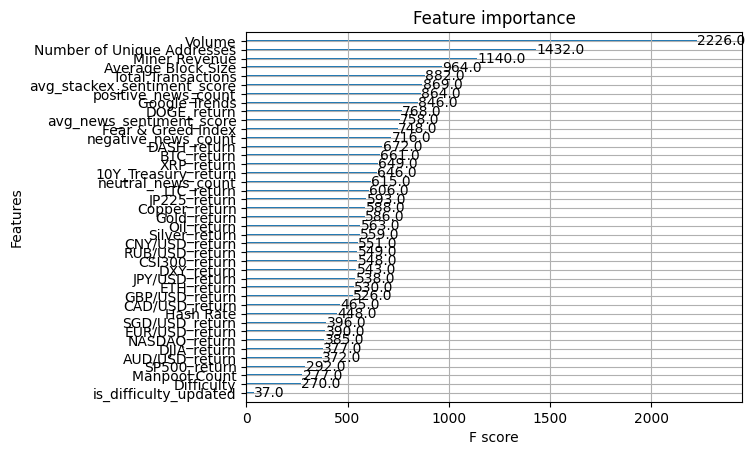

In [38]:
plot_importance(model);

In [39]:
X_test.index

DatetimeIndex(['2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08',
               '2023-09-09', '2023-09-10', '2023-09-11', '2023-09-12',
               '2023-09-13', '2023-09-14',
               ...
               '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-24',
               '2024-08-25', '2024-08-26', '2024-08-27', '2024-08-28',
               '2024-08-29', '2024-08-30'],
              dtype='datetime64[ns]', name='Date', length=361, freq=None)

In [57]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')
print(f'mean_absolute_percentage_error = {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'root squared mean error = {rmse(y_pred, y_test)}')

predictions = pd.DataFrame()
predictions["predict"] = y_pred
predictions["Date"] = X_test.index
predictions.set_index("Date")
predictions.to_csv("prediction.csv")

y_true = [-0.00103747  0.01890865 -0.01274918 -0.00038511 -0.00245026]
y_pred = [ 0.00344051 -0.00228197 -0.00017737  0.00100136  0.00050779]
mean_squared_error = 0.0007503880122345542
mean_absolute_percentage_error = 189.68555844631067
root squared mean error = 0.027393211061037627


In [ ]:
predicted_prices = data.iloc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=y,
                         name='Truth',
                         marker_color='lightgray'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices["Close"],
                         name='Prediction',
                         marker_color='navy'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=y_test,
                         name='Truth',
                         marker_color='lightgray',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices['Close'],
                         name='Prediction',
                         marker_color='navy',
                         showlegend=False), row=2, col=1)

fig.show()